# 这里主要使用的是老的rrr数据，这里的df有点问题，应该看03就行

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
input_path='./01_数据input/'

# 新的RRR变化时间

In [53]:
rrr_time='''
2010-01-12 19:00:00
2010-02-12 18:00:00
2010-05-02 18:43:27
2010-11-10 18:45:00
2010-11-19 17:59:46
2010-12-10 18:00:01
2011-01-14 17:55:26
2011-02-18 18:02:18
2011-03-18 18:20:56
2011-04-17 17:02:15
2011-05-12 18:30:02
2011-06-14 15:18:25
2011-11-30 19:03:42
2012-02-18 20:00:00
2012-05-12 19:00:00
2014-04-22 15:30:31
2014-06-09 18:51:44
2015-02-04 18:21:17
2015-04-19 17:01:07
2015-06-27 16:55:24
2015-08-25 18:15:34
2015-10-23 19:17:52
2016-02-29 18:00:00
2017-09-30 17:00:01
2018-04-17 18:26:32
2018-06-24 17:02:18
2018-10-07 11:49:46
2019-01-04 17:20:40
2019-05-06 09:29:27
2019-09-06 17:22:05
2020-01-01 15:07:56
2020-03-13 17:16:23
2020-04-03 16:57:32
'''.strip().split('\n')
rrr_time;

## 以前用的RRR时间

In [59]:
df=pd.read_excel(input_path+'法定存款准备金率.xlsx',header=1)[:-6]
df=df.sort_values('公布时间')
df=df.iloc[2:]
print(len(df))
df.head()

24


,公布时间,生效时间,调整前,调整后,调整幅度,调整前.1,调整后.1,调整幅度.1
23,2010年05月02日,2010年05月10日,16.5,17.0,0.5,14.5,15.0,0.5
22,2010年11月10日,2010年11月16日,17.0,17.5,0.5,15.0,15.5,0.5
21,2010年11月19日,2010年11月29日,17.5,18.0,0.5,15.5,16.0,0.5
20,2010年12月10日,2010年12月20日,18.0,18.5,0.5,16.0,16.5,0.5
19,2011年01月14日,2011年01月20日,18.5,19.0,0.5,16.5,16.5,0.0


In [60]:
RRR_time=df['公布时间'].apply(lambda x:datetime.datetime.strptime(x,'%Y年%m月%d日'))
RRR_time

23   2010-05-02
22   2010-11-10
21   2010-11-19
20   2010-12-10
19   2011-01-14
18   2011-02-18
17   2011-03-18
16   2011-04-17
15   2011-05-12
14   2011-06-14
13   2011-11-30
12   2012-02-18
11   2012-05-12
10   2015-02-04
9    2015-04-19
8    2015-08-25
7    2015-10-23
6    2016-02-29
5    2018-04-17
4    2018-06-24
3    2018-10-07
2    2019-01-04
1    2019-09-06
0    2020-01-01
Name: 公布时间, dtype: datetime64[ns]

## 读取IRS数据

In [61]:
irs=pd.read_excel(input_path+'IRS_ALL.xlsx',index_col=0)
irs.index=pd.DatetimeIndex(irs.index)
irs

,收盘价
日期,
2010-04-19,2.1900
2010-04-20,2.1600
2010-04-21,2.1500
2010-04-22,2.1300
2010-04-23,2.1300
...,...
2020-09-24,2.4275
2020-09-25,2.4625
2020-09-28,2.4400


<AxesSubplot:xlabel='日期'>

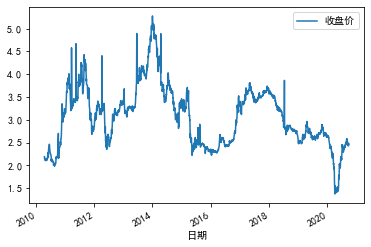

In [11]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
irs.plot()

In [56]:
# change=pd.DataFrame(index=RRR_time[RRR_time>'2010-04-19'],columns=['t1','t0','irs1','irs0'])
# for one in change.index:
#     t0=(irs[irs.index<one].index.max())
#     irs0=irs['收盘价'][t0]
#     if one in irs.index.tolist():
#         t1=one
#         irs1=irs['收盘价'][one]
#     else:
#         t1=irs[irs.index>one].index.min()
#         irs1=irs['收盘价'][t1]

#     change.loc[one]=t1,t0,irs1,irs0
# change['irs_change']=change['irs1']-change['irs0']
# change

## 此处尝试计算IRS冲击的方法，下面cell使用

* 冲击后：次日IRS
* 冲击前：当日或前一日（如果当日为非交易日）
* 也即冲击发生在我们所使用日期的收盘后？

得到的结果更为相似

同时作者使用应该是两者结合，也就是文中的方法



## 此处使用精确发布时点，记为new_rrr_time

In [64]:
new_rrr_time=[]
one_day=datetime.timedelta(days=1)
for one in rrr_time:
    t=(one[-8:])
    one_time=(datetime.datetime.strptime(one,'%Y-%m-%d %H:%M:%S'))
#     print(t)
    if t>'12:00:00': # 如果时间为超过下午四点半，则记为下一交易日（没有加一天，是因为后面的irs处理会按照下一交易日处理）
        # 这里不太对劲，根据发布时间，改为中午12点
        new_rrr_time+=[one[:10]]
#         print(t+'==')
    else: # 当前交易日
        new_rrr_time+=[str(one_time-one_day)[:10]]
#         print(t)
new_rrr_time;

## 不精确的时间

In [39]:
change=pd.DataFrame(index=RRR_time[RRR_time>'2010-04-19'],columns=['t1','t0','irs1','irs0'])
for one in change.index:
    # 如果当天存在（为交易日）则当天收盘价为初始irs
    if one in irs.index.tolist():
        t0=one
        irs0=irs['收盘价'][one]
    # 否则前一天为初始irs
    else:
        t0=irs[irs.index<one].index.max()
        irs0=irs['收盘价'][t0]
    # 冲击后irs为后一天irs
    t1=(irs[irs.index>one].index.min())
    irs1=irs['收盘价'][t1]

    change.loc[one]=t1,t0,irs1,irs0
change['irs_change']=change['irs1']-change['irs0']
change_old=change
change_old;


pd.Series(new_rrr_time)[pd.Series(new_rrr_time)>'2010-04-19']## 新的准确发布时间

In [44]:
change=pd.DataFrame(index=pd.Series(new_rrr_time)[pd.Series(new_rrr_time)>'2010-04-19'],columns=['t1','t0','irs1','irs0'])
for one in change.index:
    # 如果当天存在（为交易日）则当天收盘价为初始irs
    if one in irs.index.tolist():
        t0=one
        irs0=irs['收盘价'][one]
    # 否则前一天为初始irs
    else:
        t0=irs[irs.index<one].index.max()
        irs0=irs['收盘价'][t0]
    # 冲击后irs为后一天irs
    t1=(irs[irs.index>one].index.min())
    irs1=irs['收盘价'][t1]

    change.loc[one]=t1,t0,irs1,irs0
change['irs_change']=change['irs1']-change['irs0']
change

,t1,t0,irs1,irs0,irs_change
2010-05-02,2010-05-04 00:00:00,2010-04-29 00:00:00,2.15,2.135,0.015
2010-11-10,2010-11-11 00:00:00,2010-11-09 00:00:00,2.58,2.4466,0.1334
2010-11-19,2010-11-22 00:00:00,2010-11-18 00:00:00,2.97,2.68,0.29
2010-12-10,2010-12-13 00:00:00,2010-12-09 00:00:00,3.085,3.0982,-0.0132
2011-01-14,2011-01-17 00:00:00,2011-01-13 00:00:00,3.4,3.2,0.2
2011-02-18,2011-02-21 00:00:00,2011-02-17 00:00:00,4.01,3.85,0.16
2011-03-18,2011-03-21 00:00:00,2011-03-17 00:00:00,3.385,3.22,0.165
2011-04-17,2011-04-18 00:00:00,2011-04-15 00:00:00,3.385,3.38,0.005
2011-05-12,2011-05-17 00:00:00,2011-05-11 00:00:00,3.48,3.43,0.05
2011-06-14,2011-06-15 00:00:00,2011-06-13 00:00:00,3.79,3.48,0.31


## 计算均值、最大值、最小值

In [41]:
def mean_min_max(irs_change:pd.Series):
    abss=np.abs(irs_change)
    return '{:6f} {:6f} {:6f}'.format(abss.mean(),abss.min(),abss.max())
    
    
mean_min_max(change['irs_change'])

'0.097733 0.005000 0.300000'

In [17]:
np.abs(change['irs_change']).mean()

0.10440645161290316

In [42]:
# pd.DataFrame({'irs':(change['irs_change']*100).tolist()},index=rrr_time[2:])

## RRR冲击

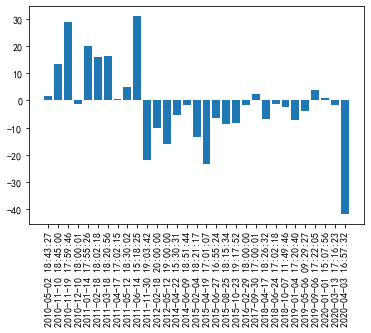

In [45]:
import re
# x=df['公布时间'].apply(lambda x:re.sub('[^\x00-\xff]','-',x)[:-1])
x=rrr_time[2:]
# plt.figure(figsize=(10,7))
plt.bar(x,change['irs_change']*100)
plt.xticks(rotation=90)
plt.show()

In [46]:
# import re
# # plt.figure(figsize=(10,7))
# plt.bar(x,df['调整幅度']*100)
# plt.xticks(rotation=90)
# plt.show()

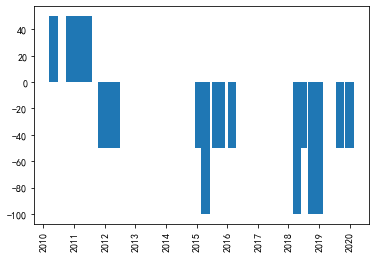

In [47]:
import re
# plt.figure(figsize=(10,7))
plt.bar(RRR_time,df['调整幅度']*100,width=100)
plt.xticks(rotation=90)
plt.show()

In [48]:
change;

ValueError: shape mismatch: objects cannot be broadcast to a single shape

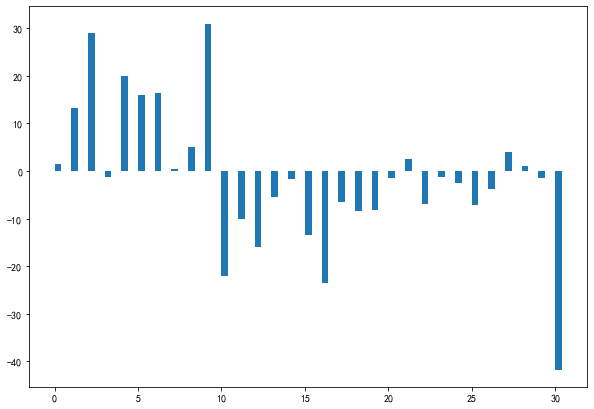

In [32]:
plt.figure(figsize=(10,7))

width=0.4

# RRR冲击
xx=np.array([i for i in range(len(x))])
x_tick=list(map(lambda x:str(x)[:10],change.index.tolist()))
plt.bar(xx+width/2,change['irs_change']*100,width=width)

# RRR实际调整幅度
y=df['调整幅度']
plt.bar(xx-width/2,y*100,width=width)

plt.legend(['IRS响应','政策变化'])
plt.xticks(xx,x,rotation=90)
plt.show()


## 接下来进行回归，首先计算当日响应(h=0)

$$∆y_{t+h,t-1} =α_h+β_hS_t+ε_{h,t}$$

In [50]:
sov_rate=pd.read_excel(input_path+'国债收益率.xlsx',index_col=0)
sov_rate.index=pd.DatetimeIndex(sov_rate.index)
sov_rate

,3m,6m,1y,3y,5y,10y
时间,,,,,,
2010-01-04,1.2372,1.4107,1.5000,2.4374,2.9584,3.6603
2010-01-05,1.2552,1.4088,1.5098,2.4591,2.9910,3.6606
2010-01-06,1.2577,1.4106,1.5238,2.4360,2.9912,3.6425
2010-01-07,1.2821,1.4126,1.5489,2.4542,3.0039,3.6543
2010-01-08,1.3221,1.4095,1.5411,2.4692,3.0340,3.6614
...,...,...,...,...,...,...
2020-10-10,2.3443,2.6010,2.7017,2.9872,3.1144,3.1898
2020-10-12,2.3747,2.6482,2.6937,3.0005,3.0893,3.1861
2020-10-13,2.3731,2.6576,2.6959,3.0026,3.1072,3.1950


In [51]:
def get_sov(tenor):
    sov=pd.DataFrame(index=RRR_time[RRR_time>'2010-04-19'],columns=['t1','t0','sov_rate1','sov_rate0'])

    for one in sov.index:
        # 与之前类似，如果当天为交易日，则本日收盘价为冲击前利率
        if one in sov_rate.index.tolist():
            t0=one
            sov_rate0=sov_rate[tenor][one]
        else:
            t0=sov_rate[sov_rate.index<one].index.max()
            sov_rate0=sov_rate[tenor][t0]
        t1=(sov_rate[sov_rate.index>one].index.min())
        sov_rate1=sov_rate[tenor][t1]

        sov.loc[one]=t1,t0,sov_rate1,sov_rate0
    sov['sov_rate_change']=sov['sov_rate1']-sov['sov_rate0']
    return sov
sov=get_sov('3m')
sov

,t1,t0,sov_rate1,sov_rate0,sov_rate_change
公布时间,,,,,
2010-05-02,2010-05-04 00:00:00,2010-04-30 00:00:00,1.3183,1.3186,-0.0003
2010-11-10,2010-11-11 00:00:00,2010-11-10 00:00:00,1.9147,1.8742,0.0405
2010-11-19,2010-11-22 00:00:00,2010-11-19 00:00:00,2.1133,2.0002,0.1131
2010-12-10,2010-12-13 00:00:00,2010-12-10 00:00:00,2.7343,2.6858,0.0485
2011-01-14,2011-01-17 00:00:00,2011-01-14 00:00:00,2.753,2.699,0.054
2011-02-18,2011-02-21 00:00:00,2011-02-18 00:00:00,2.9239,2.7675,0.1564
2011-03-18,2011-03-21 00:00:00,2011-03-18 00:00:00,2.5712,2.5,0.0712
2011-04-17,2011-04-18 00:00:00,2011-04-15 00:00:00,2.5487,2.5539,-0.0052
2011-05-12,2011-05-13 00:00:00,2011-05-12 00:00:00,2.714,2.5954,0.1186


ValueError: shape mismatch: objects cannot be broadcast to a single shape

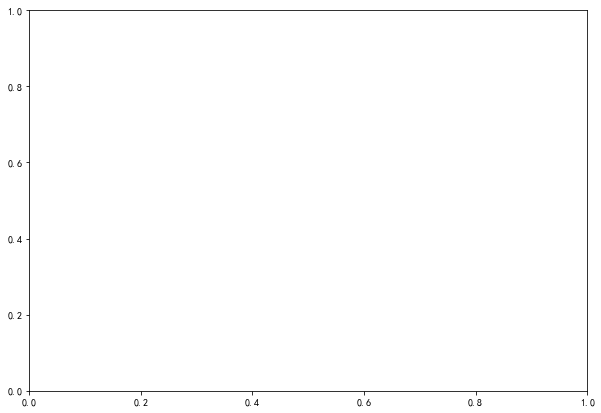

In [52]:
plt.figure(figsize=(10,7))

width=0.4

xx=np.array([i for i in range(len(x))])
x_tick=list(map(lambda x:str(x)[:10],sov.index.tolist()))
plt.bar(xx+width/2,sov['sov_rate_change']*100,width=width)

y=df['调整幅度']
plt.bar(xx-width/2,change['irs_change']*100,width=width)

plt.legend('')
plt.xticks(xx,x,rotation=90)
plt.show()


In [15]:
import statsmodels.api as sm

def reg(sov):
    # 主权债收益率变化为y，irs变化为x
    Y,X=np.array(sov['sov_rate_change'].tolist()),np.array(change['irs_change'].tolist())
    X=sm.add_constant(X)
    mod=sm.OLS(Y,X)
    res=mod.fit()
    coef,p=res.params[1],res.pvalues[1]
    #print(coef,p)
#     return res.summary()
    return coef,p
reg(sov)

(0.6695531419055025, 4.6857133172364795e-06)

In [16]:
tenor_list=['3m','6m','1y','3y','5y','10y']
est_result=pd.DataFrame(index=tenor_list,columns=['RRR','P_value'])
for tenor in tenor_list:
    sov=get_sov(tenor)
    coef,p=reg(sov)
    est_result.loc[tenor]=[coef,p]
est_result

,RRR,P_value
3m,0.669553,4.68571e-06
6m,0.63071,1.60286e-05
1y,0.599473,1.60774e-06
3y,0.369771,3.6568e-06
5y,0.375605,1.61876e-05
10y,0.326444,3.09646e-06


## 接下来我们将一日响应扩大到多日响应


In [17]:
def get_sov_nday(tenor,days):
    sov=pd.DataFrame(index=RRR_time[RRR_time>'2010-04-19'],columns=['t1','t0','sov_rate1','sov_rate0'])

    for one in sov.index:
        if one in sov_rate.index.tolist():
            t0=one
            sov_rate0=sov_rate[tenor][one]
        else:
            t0=sov_rate[sov_rate.index<one].index.max()
            sov_rate0=sov_rate[tenor][t0]
            
        t1=(sov_rate[sov_rate.index>one].index[days-1]) #主要修改了这里，n日响应对应index的n-1
        sov_rate1=sov_rate[tenor][t1]

        sov.loc[one]=t1,t0,sov_rate1,sov_rate0
    sov['sov_rate_change']=sov['sov_rate1']-sov['sov_rate0']
    return sov
sov_n=get_sov_nday('3m',1)
sov_n

,t1,t0,sov_rate1,sov_rate0,sov_rate_change
公布时间,,,,,
2010-05-02,2010-05-04 00:00:00,2010-04-30 00:00:00,1.3183,1.3186,-0.0003
2010-11-10,2010-11-11 00:00:00,2010-11-10 00:00:00,1.9147,1.8742,0.0405
2010-11-19,2010-11-22 00:00:00,2010-11-19 00:00:00,2.1133,2.0002,0.1131
2010-12-10,2010-12-13 00:00:00,2010-12-10 00:00:00,2.7343,2.6858,0.0485
2011-01-14,2011-01-17 00:00:00,2011-01-14 00:00:00,2.753,2.699,0.054
2011-02-18,2011-02-21 00:00:00,2011-02-18 00:00:00,2.9239,2.7675,0.1564
2011-03-18,2011-03-21 00:00:00,2011-03-18 00:00:00,2.5712,2.5,0.0712
2011-04-17,2011-04-18 00:00:00,2011-04-15 00:00:00,2.5487,2.5539,-0.0052
2011-05-12,2011-05-13 00:00:00,2011-05-12 00:00:00,2.714,2.5954,0.1186


In [18]:
tenor_list=['3m','6m','1y','3y','5y','10y']
# 1-7天的冲击
day_list=[i for i in range(1,8)]
est_result_nday=pd.DataFrame(index=tenor_list,columns=day_list)
for tenor in tenor_list:
    for day in day_list:
        sov=get_sov_nday(tenor,days=day) # 多日主权债收益率变化
        coef,p=reg(sov) #主权债收益率变化与irs变化回归
        est_result_nday.loc[tenor,day]=coef # 放入df中
est_result_nday

,1,2,3,4,5,6,7
3m,0.669553,0.89904,1.16844,1.18468,1.32486,1.45435,1.5483
6m,0.63071,0.835783,0.979162,0.965473,1.05297,1.16306,1.21971
1y,0.599473,0.79033,0.928698,0.927302,1.04364,1.09417,1.17509
3y,0.369771,0.517183,0.559398,0.414812,0.449736,0.518,0.521366
5y,0.375605,0.556792,0.588275,0.476202,0.49847,0.532477,0.541342
10y,0.326444,0.400161,0.411113,0.273108,0.297453,0.336412,0.358773


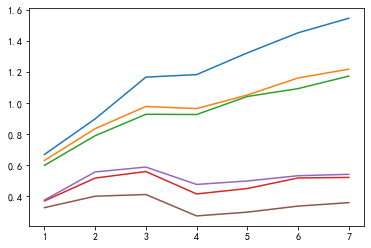

In [19]:
for year in tenor_list:
    plt.plot(est_result_nday.loc[year])
plt.show()

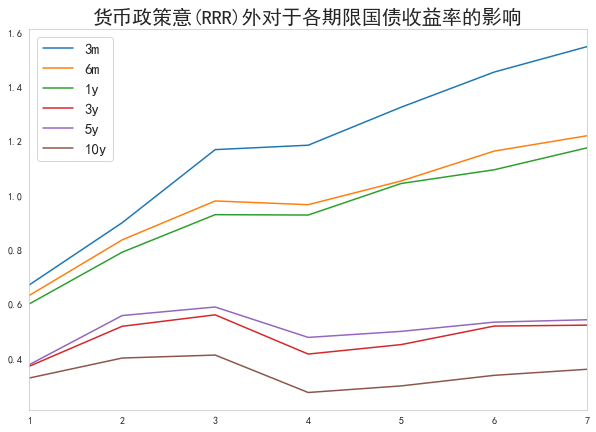

In [20]:

sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,7))
plt.plot(est_result_nday.T)
plt.title('货币政策意(RRR)外对于各期限国债收益率的影响',size=20)
plt.legend(est_result_nday.index,fontsize=15)
plt.grid()
plt.xlim(1,7)
plt.show()